# Assignment 2 group 2
Avezzù Irene e Nworah Bortot Ivana

## 1. Sentiment Analysis on Movie Reviews

Consider the `movie_sentiment_analysis.csv` dataset containing the reviews of movies along with their polarities to perform sentiment classification:

1. remove non-informative features;
2. remove punctuation and make the text lowercase, as we did in a Lab 3.
3. encode the text using a tdf-ifd vectorizer;
4. use the following classifiers (use 5-fold cross validation to find the best hyperparameters):
    - KNN (hyperparam: the number of neighbours);
    - SVM (hyperparam: C);
    - Naive Bayes (hyperparam: the kind of NB classifier);
    - Decision Trees (hyperparam: the height of the DT);
5. plot the prec-rec curve;
6. plot the roc curve;
7. plot the confusion matrix;
8. discuss the results.

### 1. Remove non informative features

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore') 

Import data

For testing purposes we can include in the read_csv the parameter nrows wich selects only the first n-th rows  
e.g. data = pd.read_csv('movie_sentiment_analysis.csv', nrows=100)

In [2]:
data = pd.read_csv('movie_sentiment_analysis.csv')
data.columns = ['fold_id', 'cv_tag', 'html_id', 'sent_id', 'text', 'tag']
data['tag'].replace({'neg':0, 'pos':1}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fold_id  64720 non-null  int64 
 1   cv_tag   64720 non-null  object
 2   html_id  64720 non-null  int64 
 3   sent_id  64720 non-null  int64 
 4   text     64720 non-null  object
 5   tag      64720 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.0+ MB


In [3]:
#check for null values
data = data.replace(['?', ',', '.'], np.NaN) #remove ? and , and . as missing values

print('Number of missing values before cleaning:')
for col in data.columns:
    print(f'\t{col}: {data[col].isna().sum()}')


Number of missing values before cleaning:
	fold_id: 0
	cv_tag: 0
	html_id: 0
	sent_id: 0
	text: 136
	tag: 0


From data.info the dataset appeared to have no null values ut when we reapleace the '?', ',' and '.' the situation changes. This is because there a no null values but '?', ',' and '.' are still considered as missing values so they need to be removed as if they were null values

We then deal the null values. There are two possible approaches:
1. substitute the null values using the method fillna
2. discard the data points using the method dropna

1 - All null values are substituted with the most frequent of the 'text' column

In [4]:
data_clean = data.copy()
data_clean['text'] = data_clean[['text']].fillna(value=data['text'].mode()[0])
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fold_id  64720 non-null  int64 
 1   cv_tag   64720 non-null  object
 2   html_id  64720 non-null  int64 
 3   sent_id  64720 non-null  int64 
 4   text     64720 non-null  object
 5   tag      64720 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.0+ MB


2 - Remove null values by removing the rows that contain them

In [5]:
print(f'Number of rows in original data = {data.shape[0]}')
data = data.dropna()
print(f'Number of rows after discarding missing values = {data.shape[0]}')
data.info() #now the number of rows has been reduced

Number of rows in original data = 64720
Number of rows after discarding missing values = 64584
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64584 entries, 0 to 64719
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fold_id  64584 non-null  int64 
 1   cv_tag   64584 non-null  object
 2   html_id  64584 non-null  int64 
 3   sent_id  64584 non-null  int64 
 4   text     64584 non-null  object
 5   tag      64584 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.4+ MB


We consider only text and tag to contain relevant informations so we drop the other columns

In [6]:
data = data.drop('html_id', axis=1) 
data = data.drop('fold_id', axis=1) 
data = data.drop('cv_tag', axis=1) 
data = data.drop('sent_id', axis=1) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64584 entries, 0 to 64719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    64584 non-null  object
 1   tag     64584 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


### 2. Remove punctuation and make the text lowercase, as we did in a Lab 3.

In [7]:
data['text'] = data['text'].str.strip().str.lower().str.replace('[^\w]', ' ')
data.head()

,text,tag
0,films adapted from comic books have had plenty...,1
1,for starters it was created by alan moore ...,1
2,to say moore and campbell thoroughly researche...,1
3,the book or graphic novel if you will ...,1
4,in other words don t dismiss this film becau...,1


In [8]:
data.info() #check all clean data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64584 entries, 0 to 64719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    64584 non-null  object
 1   tag     64584 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


### 3. Encode the text using a tdf-ifd vectorizer;

We could have also encoded the text using a *counter vectorizer* to observe if we get different classifications  
e.g. vectorizer = CountVectorizer()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Since we then use classifiers, to make the running time shorter we use only a proportionate subset of the data

In [10]:
print("Data info:\n")
data.info()

data = data.groupby('tag', group_keys=False).apply(lambda x: x.sample(frac=0.2)) # 20% of the data

print("\n\nSampled data info:\n")
data.info()

print("\n\nSampled data head:")
data.head()


Data info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64584 entries, 0 to 64719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    64584 non-null  object
 1   tag     64584 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


Sampled data info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12917 entries, 36132 to 6651
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12917 non-null  object
 1   tag     12917 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 302.7+ KB


Sampled data head:


,text,tag
36132,one moment has an astronaut flying off into sp...,0
48340,starship troopers does not succeed as an actio...,0
56438,another thing is that this movie has sections ...,0
37581,you guessed it,0
47114,however the daughter is also the god daughte...,0


In [11]:
# Vectorize text reviews to numbers using TF-IDF
x = data['text']
y = data['tag']
vec = TfidfVectorizer(stop_words='english')
X_encoded = vec.fit_transform(x)

In [12]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.25, random_state=42)

X_encoded is a sparse matrix so it means that it has many 0 values and only a few non-zero values so to save memory it saves only the non-zero values keeping also the index of the value.
Ex of element in the matrix: (0, 2697)	0.3957785227517055

### 4-7 Use the following classifiers evaluate the accuracy, F1, prec-rec curve, roc curve and the confusion matrix:
    - KNN 
    - SVM 
    - Naive Bayes
    - Decision Trees

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics

We begin by computing the positive and negative ratio to understand the imbalance of the data.

In [14]:
print(np.unique(y_test, return_counts=True)) 

neg = np.unique(y_test, return_counts=True)[1][0]
pos = np.unique(y_test, return_counts=True)[1][1]

print(f"\nNumber of pos instances: {pos}")
print(f"Number of neg instances: {neg}")

print(f"\nPositive ratio: {pos/(pos+neg)}")
print(f"Negative ratio: {neg/(pos+neg)}")

(array([0, 1], dtype=int64), array([1586, 1644], dtype=int64))

Number of pos instances: 1644
Number of neg instances: 1586

Positive ratio: 0.5089783281733746
Negative ratio: 0.49102167182662537


We observe that the classes are balanced

### KNN Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier

We need to recompute the vectorization

In [16]:
# Vectorize text reviews to numbers using TF-IDF
x = data['text']
y = data['tag']
vec = TfidfVectorizer(stop_words='english')
X_encoded = vec.fit_transform(x)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.25, random_state=42)

Train the KNN Classifier on the test set

In [17]:
# Create a k-nearest neighbours classifier
modelKNN = KNeighborsClassifier(n_neighbors=5) # Set the number of neighbours

# Fit the classifier and obtain predicted probabilities
modelKNN.fit(X_train, y_train)
y_pred = modelKNN.predict(X_test)

Accuracy and F1

In [18]:
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy with KNN classifier: ", 100*accuracy)

Accuracy with KNN classifier:  49.81424148606811


In [19]:
F1 = metrics.f1_score(y_test, y_pred)
print("F1 with KNN classifier: ", F1)

F1 with KNN classifier:  0.30399313009875484


Prec-Rec curve

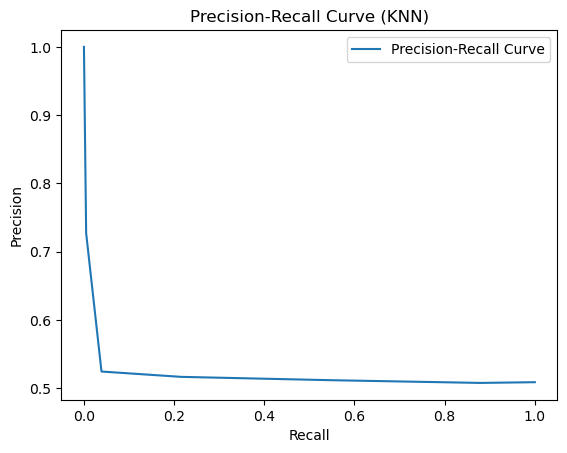

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Fit the classifier and obtain predicted probabilities
probas_pred = modelKNN.predict_proba(X_test)
probas_positive = probas_pred[:, 1]

# Calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test, probas_positive)

# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (KNN)')
plt.legend()
plt.show()

Roc curve

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc

# Split into training and testing data
x = data['text']
y = data['tag']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Convert text data into numerical features
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Create and train your classifier
classifier = KNeighborsClassifier()
classifier.fit(X_train_transformed, y_train)

# Obtain predicted probabilities for the positive class
y_score = classifier.predict_proba(X_test_transformed)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

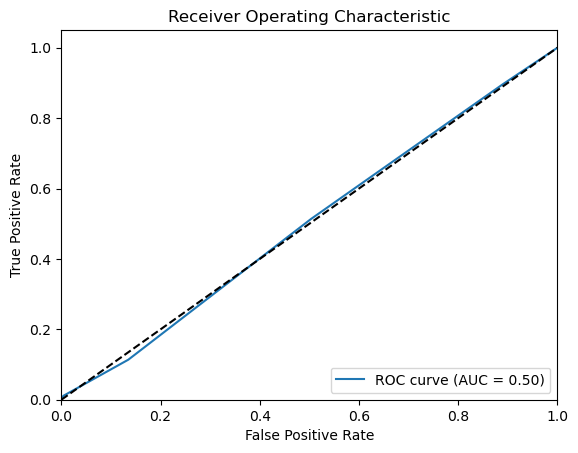

In [22]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Confusion matrix

In [23]:
from sklearn import metrics

conf_mat = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix \n",conf_mat,"\n")
print("True negative    \t",conf_mat[0][0],"--> predicted as negative, and really negative :) ")
print("False positive   \t",conf_mat[0][1]," --> predicted as positive, but negative :( ")
print("False negative  \t",conf_mat[1][0]," --> predicted as negative, but positive :( ")
print("True positive   \t",conf_mat[1][1]," --> predicted as positive, and really positive :) ")

confusion matrix 
 [[1255  331]
 [1290  354]] 

True negative    	 1255 --> predicted as negative, and really negative :) 
False positive   	 331  --> predicted as positive, but negative :( 
False negative  	 1290  --> predicted as negative, but positive :( 
True positive   	 354  --> predicted as positive, and really positive :) 


## SVM Classifier

In [24]:
from sklearn import svm

We need to recompute the vectorization

In [25]:
# Vectorize text reviews to numbers using TF-IDF
x = data['text']
y = data['tag']
vec = TfidfVectorizer(stop_words='english')
X_encoded = vec.fit_transform(x)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.25, random_state=42)

Train the classifier on the test set

In [26]:
# Train an SVM classifier and compute the accuracy score on the test set
modelSVM = svm.SVC(kernel='linear', probability=True)  # Linear Kernel
modelSVM.fit(X_train, y_train)
y_pred = modelSVM.predict(X_test)

Accuracy and F1

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with SVM classifier: ", 100*accuracy)

Accuracy with SVM classifier:  62.63157894736842


In [28]:
F1 = metrics.f1_score(y_test, y_pred)
print("F1 with SVM classifier: ", F1)

F1 with SVM classifier:  0.6289578850292038


Prec-Rec curve

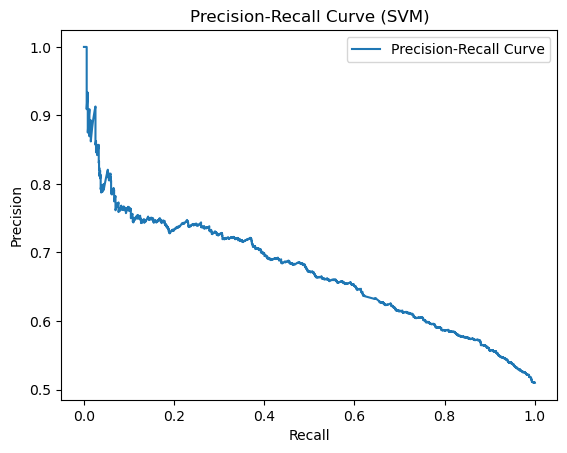

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Fit the classifier and obtain predicted probabilities
probas_pred = modelSVM.predict_proba(X_test)
probas_positive = probas_pred[:, 1]

# Calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test, probas_positive)

# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SVM)')
plt.legend()
plt.show()

Roc curve

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc

# Split into training and testing data
x = data['text']
y = data['tag']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Convert text data into numerical features
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Create and train your classifier
classifier = svm.SVC(kernel='linear', probability=True)  # Linear Kernel
classifier.fit(X_train_transformed, y_train)

# Obtain predicted probabilities for the positive class
y_score = classifier.predict_proba(X_test_transformed)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

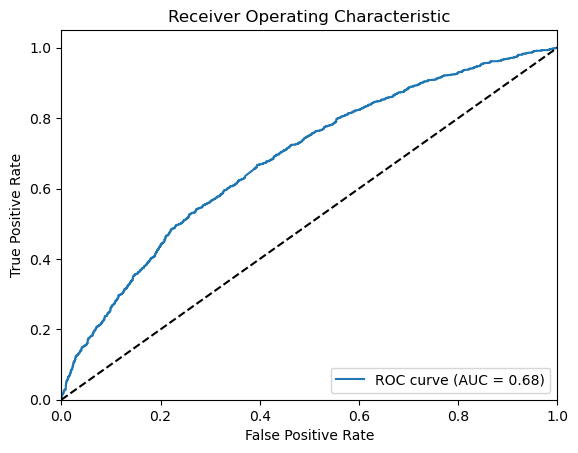

In [32]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Confusion matrix

In [33]:
from sklearn import metrics

conf_mat = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix \n",conf_mat,"\n")
print("True negative    \t",conf_mat[0][0],"--> predicted as negative, and really negative :) ")
print("False positive   \t",conf_mat[0][1]," --> predicted as positive, but negative :( ")
print("False negative  \t",conf_mat[1][0]," --> predicted as negative, but positive :( ")
print("True positive   \t",conf_mat[1][1]," --> predicted as positive, and really positive :) ")

confusion matrix 
 [[1000  586]
 [ 621 1023]] 

True negative    	 1000 --> predicted as negative, and really negative :) 
False positive   	 586  --> predicted as positive, but negative :( 
False negative  	 621  --> predicted as negative, but positive :( 
True positive   	 1023  --> predicted as positive, and really positive :) 


## Naive Bayes Classifier

In [34]:
from sklearn.naive_bayes import MultinomialNB

We need to recompute the vectorization

In [35]:
# Vectorize text reviews to numbers using TF-IDF
x = data['text']
y = data['tag']
vec = TfidfVectorizer(stop_words='english')
X_encoded = vec.fit_transform(x)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.25, random_state=42)

Train the classifier on the test set

In [36]:
modelNB = MultinomialNB()
modelNB.fit(X_train, y_train)
y_pred = modelNB.predict(X_test)

Accuracy and F1

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Naive Bayes classifier: ", 100*accuracy)

Accuracy with Naive Bayes classifier:  64.52012383900929


In [38]:
F1 = metrics.f1_score(y_test, y_pred)
print("F1 with Naive Bayes classifier: ", F1)

F1 with Naive Bayes classifier:  0.659131469363474


Prec-rec curve

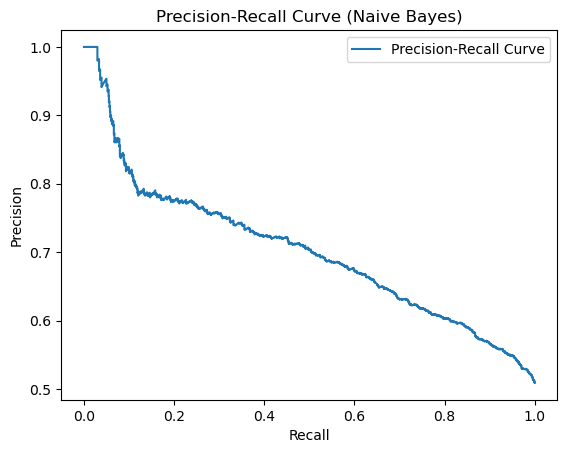

In [39]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Fit the classifier and obtain predicted probabilities
probas_pred = modelNB.predict_proba(X_test)
probas_positive = probas_pred[:, 1]

# Calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test, probas_positive)

# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Naive Bayes)')
plt.legend()
plt.show()

Roc curve

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc

# Split into training and testing data
x = data['text']
y = data['tag']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Convert text data into numerical features
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Create and train your classifier
classifier = MultinomialNB()
classifier.fit(X_train_transformed, y_train)

# Obtain predicted probabilities for the positive class
y_score = classifier.predict_proba(X_test_transformed)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

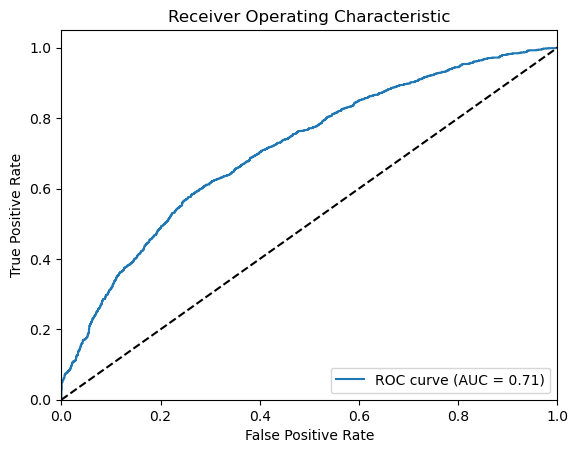

In [41]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Confusion matrix

In [42]:
from sklearn import metrics

conf_mat = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix \n",conf_mat,"\n")
print("True negative    \t",conf_mat[0][0],"--> predicted as negative, and really negative :) ")
print("False positive   \t",conf_mat[0][1]," --> predicted as positive, but negative :( ")
print("False negative  \t",conf_mat[1][0]," --> predicted as negative, but positive :( ")
print("True positive   \t",conf_mat[1][1]," --> predicted as positive, and really positive :) ")

confusion matrix 
 [[ 976  610]
 [ 536 1108]] 

True negative    	 976 --> predicted as negative, and really negative :) 
False positive   	 610  --> predicted as positive, but negative :( 
False negative  	 536  --> predicted as negative, but positive :( 
True positive   	 1108  --> predicted as positive, and really positive :) 


## Decision Tree Classifier

In [43]:
from sklearn.tree import DecisionTreeClassifier

We need to recompute the vectorization

In [44]:
# Vectorize text reviews to numbers using TF-IDF
x = data['text']
y = data['tag']
vec = TfidfVectorizer(stop_words='english')
X_encoded = vec.fit_transform(x)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.25, random_state=42)

Train the classifier on the test set

In [45]:
modelDT = DecisionTreeClassifier()
modelDT.fit(X_train, y_train)
y_pred = modelDT.predict(X_test)

Accuracy and F1

In [46]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Decision Trees classifier: ", 100*accuracy)

Accuracy with Decision Trees classifier:  54.27244582043343


In [47]:
F1 = metrics.f1_score(y_test, y_pred)
print("F1 with Decision Trees classifier: ", F1)

F1 with Decision Trees classifier:  0.5209211806681804


Prec-rec curve

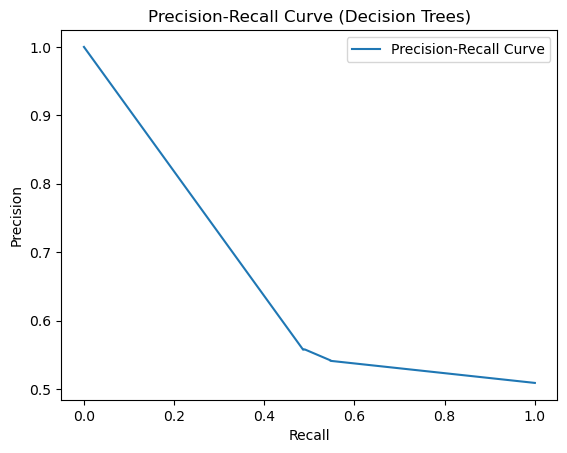

In [48]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Fit the classifier and obtain predicted probabilities
probas_pred = modelDT.predict_proba(X_test)
probas_positive = probas_pred[:, 1]

# Calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test, probas_positive)

# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Decision Trees)')
plt.legend()
plt.show()

Roc curve

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc

# Split into training and testing data
x = data['text']
y = data['tag']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Convert text data into numerical features
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Create and train your classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_transformed, y_train)

# Obtain predicted probabilities for the positive class
y_score = classifier.predict_proba(X_test_transformed)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

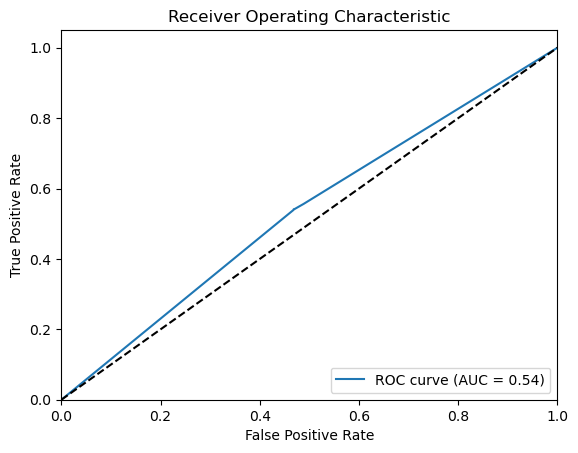

In [50]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Confusion matrix

In [51]:
from sklearn import metrics

conf_mat = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix \n",conf_mat,"\n")
print("True negative    \t",conf_mat[0][0],"--> predicted as negative, and really negative :) ")
print("False positive   \t",conf_mat[0][1]," --> predicted as positive, but negative :( ")
print("False negative  \t",conf_mat[1][0]," --> predicted as negative, but positive :( ")
print("True positive   \t",conf_mat[1][1]," --> predicted as positive, and really positive :) ")

confusion matrix 
 [[950 636]
 [841 803]] 

True negative    	 950 --> predicted as negative, and really negative :) 
False positive   	 636  --> predicted as positive, but negative :( 
False negative  	 841  --> predicted as negative, but positive :( 
True positive   	 803  --> predicted as positive, and really positive :) 


### 8. discuss the results.

See Conlusion.pdf file

## 2. Clustering of wine types

1. perform Kmeans with several values for K (that is the number of clusters) for the wine dataset in Sklearn: `wine = load_wine()`;
(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html)
2. use the Elbow method for choosing a right number for K and perform the clustering;
3. as the wine dataset provides the true labels in `wine.target` compute the accuracy and the confusion matrix (search the relative Sklearn functions):
    - the cluster labels computed by kmeans are just artificial labels that do not share anything with the true labels. You have to infer the predicted labels from the clusters by using the true labels in `wine.target`. You can use a voting criterion: the predicted cluster label will be the one with more instances in the cluster. For example, if a cluster contains images corresponding to these faces [1,2,3,1,1,1], then the cluster label will be with 1.
4. Give your own comments and analysis on points 1, 2 and 3. Does the plots in points 2 and 3 indicate the same value for K?

### 1. Perform Kmeans with several values for K (that is the number of clusters) for the wine dataset in Sklearn

In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore') 

Import data

In [45]:
wine = load_wine(as_frame=True)
wine = wine.frame
wine.info()
wine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


All columns contain relevant information

We check for null values

In [46]:
#check for null values
wine = wine.replace(['?', ',', '.'], np.NaN) #remove ? and , and . as missing values

print('Number of missing values before cleaning:')
for col in wine.columns:
    print(f'\t{col}: {wine[col].isna().sum()}')

Number of missing values before cleaning:
	alcohol: 0
	malic_acid: 0
	ash: 0
	alcalinity_of_ash: 0
	magnesium: 0
	total_phenols: 0
	flavanoids: 0
	nonflavanoid_phenols: 0
	proanthocyanins: 0
	color_intensity: 0
	hue: 0
	od280/od315_of_diluted_wines: 0
	proline: 0
	target: 0


Since there are no null values we don't need to remove any element of the dataset

K-Means requires unlabeled data in order to run so we take the date without labels to the clustering


We compute the clustering on a copy of the dataset without the column "target", we don't drop the column from the original dataset because we will need it later to evaluate the accuracy

In [47]:
data_to_cluster = wine.copy()
data_to_cluster = data_to_cluster.drop('target', axis =1)

wine.info()

data_to_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

Once we remove the target column we execute clustering with different values of cluster  
number_of_clusters = [2, 3, 4, 5, 6, 7]

Each label array has 178 elements wich is the total number of elements in the data_to_cluster dataset 

Each cluster center has 13 values, one for each dimension (column of the dataset)

In [48]:
# K-Means requires unlabeled data in order to run so we take the date without labels to the clustering
X = data_to_cluster.values 
number_of_clusters = [2, 3, 4, 5, 6, 7] #we test the clustering with different possible number of clusters
predicted_belonging_cluster = [] #nullcontext, nullcontext, nullcontext, nullcontext, nullcontext, nullcontext]

for K in number_of_clusters: 
    clustering = KMeans(n_clusters=K)
    belonging_cluster = clustering.fit_predict(X)
    predicted_belonging_cluster.append(belonging_cluster)
    
    print(f"\nNumber of clusters: {K}")
    print("Cluster centers: ")
    print(clustering.cluster_centers_)
    print("Cluster to which element belongs: ")
    print(belonging_cluster)


Number of clusters: 2
Cluster centers: 
[[1.27028455e+01 2.54455285e+00 2.33910569e+00 2.04081301e+01
  9.68130081e+01 2.06211382e+00 1.64146341e+00 3.92682927e-01
  1.45406504e+00 4.85138211e+00 9.08617886e-01 2.40821138e+00
  5.65869919e+02]
 [1.36665455e+01 1.87072727e+00 2.42781818e+00 1.74527273e+01
  1.06290909e+02 2.81618182e+00 2.89654545e+00 2.92909091e-01
  1.89690909e+00 5.52036364e+00 1.06665455e+00 3.06672727e+00
  1.15172727e+03]]
Cluster to which element belongs: 
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Number of clusters: 3
Cluster centers: 
[[1.29298387e+01 2.50403226e+00 2.40806452e+00 1.98903226e+01
  1.03596774e+02 2.11112903e+00 1.58403226e+00 3.8

### 2. Use the Elbow method for choosing a right number for K and perform the clustering;

In [1]:
plt.figure()
inertia = []
number_of_clusters = [i for i in range(1, 10)]
for K in number_of_clusters:
    clustering = KMeans(n_clusters=K)
    clustering.fit(X)
    inertia.append(clustering.inertia_)
    
plt.plot(number_of_clusters, inertia, "o-")
plt.xlabel("k")
plt.ylabel("inertia")

NameError: name 'plt' is not defined

### 3. Compute the accuracy and the confusion matrix (search the relative Sklearn functions):

Observing the graph of the elbow method we deduce that the optimal number of clusters is four

In [50]:
wine['target'].unique()

array([0, 1, 2])

To evaluate the accuracy we need to compare the actual labels (target column), with the predited labels evaluated with the majority vote

In [51]:
y_test = wine['target'].values

To evaluate the majority vote for each cluster we divide the actual label in the 4 clusters

In [53]:
belonging_cluster = predicted_belonging_cluster[2] #the third element of the array contains the predicted belonging cluster for K=4
print("Predicted belonging cluster: \n", belonging_cluster)
belonging_cluster_0 = []
belonging_cluster_1 = []
belonging_cluster_2 = []
belonging_cluster_3 = []
for index, value in enumerate(belonging_cluster):
    #index = index of the element in the dataset, y_true[index] = actual label of the element
    element = [index, y_test[index]] 
    if (value == 0):
        belonging_cluster_0.append(element) 
    elif (value == 1):
        belonging_cluster_1.append(element)
    elif (value == 2):
        belonging_cluster_2.append(element)
    elif(value == 3):
        belonging_cluster_3.append(element)

print("\nCluster 0: ", belonging_cluster_0)
print("Cluster 1: ", belonging_cluster_1)
print("Cluster 2: ", belonging_cluster_2)
print("Cluster 3: ", belonging_cluster_3)


Predicted belonging cluster: 
 [0 0 2 2 3 2 2 2 0 0 2 2 2 0 2 2 2 0 2 0 3 3 0 0 0 3 2 2 0 0 2 2 0 2 0 0 0
 0 0 3 3 0 0 3 0 0 0 0 0 2 0 2 2 2 0 0 0 2 2 1 3 1 3 1 1 3 1 1 3 3 0 1 1 0
 0 1 1 1 3 1 1 3 3 1 1 1 1 1 3 3 1 1 1 1 1 0 3 1 3 1 3 1 1 1 3 1 1 1 1 3 1
 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 3 1 1 3 3 3 3 1 3 3 3 3 1 1 0 3 1 3
 3 1 1 1 1 3 3 3 1 0 3 3 1 3 3 3 3 1 3 3 3 3 1 1 3 3 3 3 3 1]

Cluster 0:  [[0, 0], [1, 0], [8, 0], [9, 0], [13, 0], [17, 0], [19, 0], [22, 0], [23, 0], [24, 0], [28, 0], [29, 0], [32, 0], [34, 0], [35, 0], [36, 0], [37, 0], [38, 0], [41, 0], [42, 0], [44, 0], [45, 0], [46, 0], [47, 0], [48, 0], [50, 0], [54, 0], [55, 0], [56, 0], [70, 1], [73, 1], [74, 1], [95, 1], [144, 2], [157, 2]]
Cluster 1:  [[59, 1], [61, 1], [63, 1], [64, 1], [66, 1], [67, 1], [71, 1], [72, 1], [75, 1], [76, 1], [77, 1], [79, 1], [80, 1], [83, 1], [84, 1], [85, 1], [86, 1], [87, 1], [90, 1], [91, 1], [92, 1], [93, 1], [94, 1], [97, 1], [99, 1], [101, 1], [102, 1], [103, 1], [105, 1], [1

We then procede by evaluating the count of each label for each cluster

In [54]:
count_0 = 0
count_1 = 0
count_2 = 0

for i in range (len(belonging_cluster_0)):
    value = belonging_cluster_0[i][1]
    if (value == 0):
        count_0 += 1
    elif (value == 1):
        count_1 += 1
    else:
        count_2 += 1

#majority vote
if (count_0>count_1):
    if(count_0>count_2):
        max_count = 0
    else:
        max_count = 2
else:
    if(count_1>count_2):
        max_count = 1
    else:
        max_count = 2

print("Count of label 0 in cluster 0: ", count_0)
print("Count of label 1 in cluster 0: ", count_1)
print("Count of label 2 in cluster 0: ", count_2)
print("The majority vote assign to the cluster 0 the label: ", max_count)

Count of label 0 in cluster 0:  29
Count of label 1 in cluster 0:  4
Count of label 2 in cluster 0:  2
The majority vote assign to the cluster 0 the label:  0


In [55]:
count_0 = 0
count_1 = 0
count_2 = 0

for i in range (len(belonging_cluster_1)):
    value = belonging_cluster_1[i][1]
    if (value == 0):
        count_0 += 1
    elif (value == 1):
        count_1 += 1
    else:
        count_2 += 1

#majority vote
if (count_0>count_1):
    if(count_0>count_2):
        max_count = 0
    else:
        max_count = 2
else:
    if(count_1>count_2):
        max_count = 1
    else:
        max_count = 2

print("Count of label 0 in cluster 0: ", count_0)
print("Count of label 1 in cluster 0: ", count_1)
print("Count of label 2 in cluster 0: ", count_2)
print("The majority vote assign to the cluster 0 the label: ", max_count)

Count of label 0 in cluster 0:  0
Count of label 1 in cluster 0:  49
Count of label 2 in cluster 0:  16
The majority vote assign to the cluster 0 the label:  1


In [56]:
count_0 = 0
count_1 = 0
count_2 = 0

for i in range (len(belonging_cluster_2)):
    value = belonging_cluster_2[i][1]
    if (value == 0):
        count_0 += 1
    elif (value == 1):
        count_1 += 1
    else:
        count_2 += 1

#majority vote
if (count_0>count_1):
    if(count_0>count_2):
        max_count = 0
    else:
        max_count = 2
else:
    if(count_1>count_2):
        max_count = 1
    else:
        max_count = 2

print("Count of label 0 in cluster 0: ", count_0)
print("Count of label 1 in cluster 0: ", count_1)
print("Count of label 2 in cluster 0: ", count_2)
print("The majority vote assign to the cluster 0 the label: ", max_count)

Count of label 0 in cluster 0:  23
Count of label 1 in cluster 0:  0
Count of label 2 in cluster 0:  0
The majority vote assign to the cluster 0 the label:  0


In [57]:
count_0 = 0
count_1 = 0
count_2 = 0

for i in range (len(belonging_cluster_3)):
    value = belonging_cluster_3[i][1]
    if (value == 0):
        count_0 += 1
    elif (value == 1):
        count_1 += 1
    else:
        count_2 += 1

#majority vote
if (count_0>count_1):
    if(count_0>count_2):
        max_count = 0
    else:
        max_count = 2
else:
    if(count_1>count_2):
        max_count = 1
    else:
        max_count = 2

print("Count of label 0 in cluster 0: ", count_0)
print("Count of label 1 in cluster 0: ", count_1)
print("Count of label 2 in cluster 0: ", count_2)
print("The majority vote assign to the cluster 0 the label: ", max_count)

Count of label 0 in cluster 0:  7
Count of label 1 in cluster 0:  18
Count of label 2 in cluster 0:  30
The majority vote assign to the cluster 0 the label:  2


Once we evaluate the majority vote we can compute the y_pred

In [58]:
y_pred = []
indexes_cluster_0 = [element[0] for element in belonging_cluster_0]
indexes_cluster_1 = [element[0] for element in belonging_cluster_1]
indexes_cluster_2 = [element[0] for element in belonging_cluster_2]
indexes_cluster_3 = [element[0] for element in belonging_cluster_3]
for i in range (178): #there are 178 elements in the dataset
    if(i in indexes_cluster_0):
        y_pred.append(0) #the majority vote assign to the cluster 0 the label 0
    elif(i in indexes_cluster_1):
        y_pred.append(1) #the majority vote assign to the cluster 0 the label 1
    elif(i in indexes_cluster_2):
        y_pred.append(0) #the majority vote assign to the cluster 0 the label 0
    elif(i in indexes_cluster_3):
        y_pred.append(2) #the majority vote assign to the cluster 0 the label 2

y_pred = np.array(y_pred) #we convert the list in a numpy array

In [59]:
y_pred

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2,
       1, 1, 2, 2, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2,
       2, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1])

Now that we have finally defined the predicted and expected labels we can evaluate the accuracy and the confusion matrix

In [66]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.7359550561797753


In [61]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_pred) #labels, cluster_labels_pred

In [64]:
print("Confusion matrix: \n",conf_mat,"\n")
print("True 0    \t",conf_mat[0][0],"--> predicted as 0, and really 0 :) ")
print("False 0   \t",(conf_mat[0][1] + conf_mat[0][2])," --> predicted as 0, but actually 1 or 2 :( ")
print("True 1    \t",conf_mat[1][1],"--> predicted as 1, and really 1 :) ")
print("False 1   \t",(conf_mat[1][0] + conf_mat[1][2])," --> predicted as 1, but actually 0 or 2 :( ")
print("True 2    \t",conf_mat[2][2],"--> predicted as 2, and really 2 :) ")
print("False 2   \t",(conf_mat[2][0] + conf_mat[2][1])," --> predicted as 2, but actually 0 or 1 :( ")

Confusion matrix: 
 [[52  0  7]
 [ 4 49 18]
 [ 2 16 30]] 

True 0    	 52 --> predicted as 0, and really 0 :) 
False 0   	 7  --> predicted as 0, but actually 1 or 2 :( 
True 1    	 49 --> predicted as 1, and really 1 :) 
False 1   	 22  --> predicted as 1, but actually 0 or 2 :( 
True 2    	 30 --> predicted as 2, and really 2 :) 
False 2   	 18  --> predicted as 2, but actually 0 or 1 :( 


### 4. Give your own comments and analysis on points 1, 2 and 3.

We used the elbow method to determine the optimal number of clusters. Since the target variable in the wine dataset has three possible values, K=1 and K=2 were not considered sufficient. We observed that there was little difference between K=3 and K=4, but we chose K=4 for greater precision in our analysis, since after that the curve doesn't drop as drastically as with K=2, and K=3.

The accuracy achieved is not the optimal, but is still a good score. It is worth noting that increasing the number of clusters could potentially improve the accuracy, but only to a limited extent. This is because K=4, is already considered a good number of clusters.

Regarding the performance of the clusters, they seem to excel in identifying instances belonging to class 0. In fact, they achieve almost perfect recognition. However, when it comes to classes 1 and 2, the performance drops to approximately 60%. This means that the clusters have a lower accuracy in distinguishing between class 1 and class 2 instances.